# **Parallelize workloads with Dask Delayed**

Dask.delayed is a simple and powerful way to parallelize existing code. It allows users to delay function calls into a task graph with dependencies. Dask.delayed doesn't provide any fancy parallel algorithms like Dask.dataframe, but it does give the user complete control over what they want to build.

Systems like Dask.dataframe are built with Dask.delayed. If you have a problem that is paralellizable, but isn't as simple as just a big array or a big dataframe, then dask.delayed may be the right choice for you.



In [1]:
import dask
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)
client


Client Scheduler: tcp://127.0.0.1:34181 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 8.18 GB


### **Simple functions**

In [2]:
import random
import time 

def inc(x):
    time.sleep(random.random())
    return x + 1

def dec(x):
    time.sleep(random.random())
    return x - 1
    
def add(x, y):
    time.sleep(random.random())
    return x + y

Normal execution

In [3]:
x = inc(1)
y = dec(5)
z = add(x,y)
z

6

In [4]:
inc = dask.delayed(inc)
'''
@delayed
def inc(x):
    time.sleep(random.random())
    return x + 1

'''
dec = dask.delayed(dec)
add = dask.delayed(add)

In [14]:
x = inc(1)
y = dec(2)
z = add(x, y)
z

Delayed('add-3f4ee0a5-b0a7-4b96-ba0d-15cff508941b')

In [16]:
#getting the dask graph
dict(z.dask)

{'add-4580525b-bece-42e7-b3bb-6c43f0787100': (<function __main__.add(x, y)>,
  'inc-4268b48b-87ff-4a2d-a425-d8248c9901d2',
  'dec-58b80bb5-6252-4eb8-bece-5408f99f83b2'),
 'inc-4268b48b-87ff-4a2d-a425-d8248c9901d2': (<function __main__.inc(x)>, 255),
 'dec-58b80bb5-6252-4eb8-bece-5408f99f83b2': (<function __main__.dec(x)>,
  'inc-4268b48b-87ff-4a2d-a425-d8248c9901d2')}

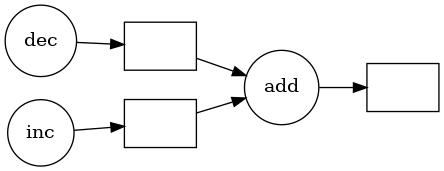

In [20]:
z.visualize(rankdir='LR')

In [21]:
z.compute()

3

In [5]:
zs = []
for i in range(256):
    x = inc(i)
    y = dec(x)
    z = add(x, y)
    zs.append(z)

In [6]:
#zs 

In [7]:
zs = dask.persist(*zs)

In [11]:

L = zs
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = add(L[i], L[i + 1])  # add neighbors
        new_L.append(lazy)
    L = new_L                       # swap old list for new

dask.compute(L)

([65536],)

In [9]:
# client.cluster.scale(10)  # ask for ten 4-thread workers
#

In [9]:
client.close()

## **NOTE** :
### **Dask is a graph execution engine**
Dask allows you to construct a prescription for the calculation you want to carry out. 